In [1]:
import json
import pandas as pd
import base64

In [2]:
insurance_claims_data = pd.read_csv("insurance_claims.csv")
insurance_claims_data = insurance_claims_data.drop(columns=['incident_date', 'policy_bind_date'])

Load everything and randomly check few artifacts' state

In [3]:
!seldon model load -f ./models/insurance_claims/calculate_claim_value.yaml
!seldon model load -f ./models/insurance_claims/classify_claim_value.yaml
!seldon model load -f ./models/insurance_claims/classify_claim_complexity.yaml
!seldon model load -f ./models/insurance_claims/classify_claim_complexity_with_bug.yaml
!seldon model load -f ./models/insurance_claims/calculate_complex_claim_payout.yaml
!seldon model load -f ./models/insurance_claims/calculate_simple_claim_payout.yaml


!seldon pipeline load -f ./pipelines/insurance_claims.yaml
!seldon pipeline load -f ./pipelines/insurance_claims_with_bug.yaml

{}
{}
{}
{}
{}
{}
{}
{}


In [4]:
!seldon model status calculate_claim_value | jq -M . | grep state
!seldon model status classify_claim_complexity_with_bug | jq -M . | grep state

          "state": "Available",
      "state": {
        "state": "ModelAvailable",
          "state": "Available",
      "state": {
        "state": "ModelAvailable",


In [5]:
!seldon pipeline status insurance_claims | jq -M . | grep status
!seldon pipeline status insurance_claims_with_bug | jq -M . | grep status

        "status": "PipelineReady",
        "status": "PipelineReady",


Dataset generation routines

In [53]:
pandas_request_types_map = {
    "int64": "INT64",
    "float64": "FP64",
    "object": "BYTES"
}

def get_triton_request_string(insurance_claims_dataset, claim_index):
    records = []
    for column_name, column_type in zip(insurance_claims_dataset.columns, insurance_claims_dataset.dtypes):
        if not str(column_type) in pandas_request_types_map:
            continue

        request_type = pandas_request_types_map[str(column_type)]
        data = insurance_claims_dataset.iloc[claim_index:claim_index+1, :][column_name].tolist()

        content = {
            "name": column_name,
            "contents": {request_type.lower() + "_contents": data},
            "datatype": request_type,
            "shape": [1]
        }

        if column_type == "object":
            content["contents"]["bytes_contents"] = [base64.b64encode(x.encode()).decode() for x in content["contents"]["bytes_contents"]]

        records.append(content)

    claim_id = {"name": "claim_id", "contents": {"int64_contents": [claim_index]}, "datatype": "INT64", "shape": [1]}
    records.append(claim_id)
    request = {
        "model_name": "does-this-matter?",
        "inputs": records
    }

    request_string = json.dumps(request)
    return request_string


def get_data_from_inspect_lines(inspect_lines, in_out_key, field_name, content_type_key):
    # inspect_lines - output of `seldon pipeline inspect`
    # in_out_key - either "inputs" or "outputs"
    # field_names - name of the field we are looking for
    # content_type_key - either "int64Contents" or "fp64Contents" or "boolContents"

    data = {}
    for line in inspect_lines:
        tokens = line.split("\t")
        request_id = tokens[1]
        payload = tokens[2]
        payload = json.loads(payload)
        payload_data = payload[in_out_key]
        field_data = next(iter([field for field in payload_data if field["name"] == field_name]), None)
        if field_data is None:
            continue

        field_value = field_data["contents"][content_type_key][0]
        if content_type_key == "boolContents":
            field_value = 1.0
        data[request_id] = float(field_value)
    
    return data

In [68]:
def generate_dataset(insurance_claims_dataset, claim_indexes, with_bug=False):
    for i in claim_indexes:
        request_string = get_triton_request_string(insurance_claims_dataset, i)
        if with_bug:
            _ = !seldon pipeline infer insurance_claims_with_bug --inference-mode grpc '{request_string}' | jq . | grep -A 1 "fp64Contents" | grep -v "fp64Contents"
        else:
            _ = !seldon pipeline infer insurance_claims --inference-mode grpc '{request_string}' | jq . | grep -A 1 "fp64Contents" | grep -v "fp64Contents"
    
    n_claims = len(claim_indexes)

    if with_bug:
        # inputs
        lines = !seldon pipeline inspect --offset '{n_claims}' insurance_claims_with_bug.inputs
        input_data = get_data_from_inspect_lines(lines, "inputs", "total_claim_amount", "int64Contents")
        # calculate_claim_value
        lines = !seldon pipeline inspect --offset '{n_claims}' insurance_claims_with_bug.calculate_claim_value.outputs
        calculate_claim_value_data = get_data_from_inspect_lines(lines, "outputs", "claim_value", "fp64Contents")

        # classify_claim_value
        lines = !seldon pipeline inspect --offset '{n_claims}' insurance_claims_with_bug.classify_claim_value.outputs
        low_value_claims_data = get_data_from_inspect_lines(lines, "outputs", "is_low_value_claim", "boolContents")
        high_value_claims_data = get_data_from_inspect_lines(lines, "outputs", "is_high_value_claim", "boolContents")

        # classify_claim_complexity - with bug!
        lines = !seldon pipeline inspect --offset '{n_claims}' insurance_claims_with_bug.classify_claim_complexity_with_bug.outputs
        complex_claims_data = get_data_from_inspect_lines(lines, "outputs", "is_complex_claim", "boolContents")
        simple_claims_data = get_data_from_inspect_lines(lines, "outputs", "is_simple_claim", "boolContents")
        # # classify_claim_complexity - with bug!
        # lines = !seldon pipeline inspect --offset '{n_claims}' insurance_claims_with_bug.classify_claim_complexity_with_bug.inputs
        # classify_claim_complexity_data = get_data_from_inspect_lines(lines, "inputs", "total_claim_amount", "int64Contents")

        # calculate_simple_claim_payout
        lines = !seldon pipeline inspect --offset '{n_claims}' insurance_claims_with_bug.calculate_simple_claim_payout.outputs
        calculate_simple_claim_payout_data = get_data_from_inspect_lines(lines, "outputs", "claim_payout", "fp64Contents")
        # calculate_complex_claim_payout
        lines = !seldon pipeline inspect --offset '{n_claims}' insurance_claims_with_bug.calculate_complex_claim_payout.outputs
        calculate_complex_claim_payout_data = get_data_from_inspect_lines(lines, "outputs", "claim_payout", "fp64Contents")

        # outputs
        lines = !seldon pipeline inspect --offset '{n_claims}' insurance_claims_with_bug.outputs
        output_data = get_data_from_inspect_lines(lines, "outputs", "claim_payout", "fp64Contents")
    else:
        # inputs
        lines = !seldon pipeline inspect --offset '{n_claims}' insurance_claims.inputs
        input_data = get_data_from_inspect_lines(lines, "inputs", "total_claim_amount", "int64Contents")
        # calculate_claim_value
        lines = !seldon pipeline inspect --offset '{n_claims}' insurance_claims.calculate_claim_value.outputs
        calculate_claim_value_data = get_data_from_inspect_lines(lines, "outputs", "claim_value", "fp64Contents")

        # classify_claim_value
        lines = !seldon pipeline inspect --offset '{n_claims}' insurance_claims.classify_claim_value.outputs
        low_value_claims_data = get_data_from_inspect_lines(lines, "outputs", "is_low_value_claim", "boolContents")
        high_value_claims_data = get_data_from_inspect_lines(lines, "outputs", "is_high_value_claim", "boolContents")

        # classify_claim_complexity - no bug!
        lines = !seldon pipeline inspect --offset '{n_claims}' insurance_claims.classify_claim_complexity.outputs
        complex_claims_data = get_data_from_inspect_lines(lines, "outputs", "is_complex_claim", "boolContents")
        simple_claims_data = get_data_from_inspect_lines(lines, "outputs", "is_simple_claim", "boolContents")
        # # classify_claim_complexity - no bug!
        # lines = !seldon pipeline inspect --offset '{n_claims}' insurance_claims.classify_claim_complexity.inputs
        # classify_claim_complexity_data = get_data_from_inspect_lines(lines, "inputs", "total_claim_amount", "int64Contents")

        # calculate_simple_claim_payout
        lines = !seldon pipeline inspect --offset '{n_claims}' insurance_claims.calculate_simple_claim_payout.outputs
        calculate_simple_claim_payout_data = get_data_from_inspect_lines(lines, "outputs", "claim_payout", "fp64Contents")
        # calculate_complex_claim_payout
        lines = !seldon pipeline inspect --offset '{n_claims}' insurance_claims.calculate_complex_claim_payout.outputs
        calculate_complex_claim_payout_data = get_data_from_inspect_lines(lines, "outputs", "claim_payout", "fp64Contents")
        # outputs
        lines = !seldon pipeline inspect --offset '{n_claims}' insurance_claims.outputs
        output_data = get_data_from_inspect_lines(lines, "outputs", "claim_payout", "fp64Contents")

    dataset = {
        'input':[], 'calculate_claim_value':[],
        'low_value_claims':[], 'high_value_claims':[],
        'simple_claims': [], 'complex_claims':[],
        'calculate_simple_claim_payout':[], 'calculate_complex_claim_payout':[],
        'output':[]
    }
    for request_id in input_data:
        dataset['input'].append(input_data[request_id])
        dataset['calculate_claim_value'].append(calculate_claim_value_data.get(request_id, None))
        dataset['low_value_claims'].append(low_value_claims_data.get(request_id, None))
        dataset['high_value_claims'].append(high_value_claims_data.get(request_id, None))
        dataset['simple_claims'].append(simple_claims_data.get(request_id, None))
        dataset['complex_claims'].append(complex_claims_data.get(request_id, None))
        dataset['calculate_simple_claim_payout'].append(calculate_simple_claim_payout_data.get(request_id, None))
        dataset['calculate_complex_claim_payout'].append(calculate_complex_claim_payout_data.get(request_id, None))
        dataset['output'].append(output_data.get(request_id, None))
    
    return pd.DataFrame(dataset)


In [79]:
n_claims = 500

## Proof of concept datasets

In [69]:
# normal data, normal app
input_data_df = insurance_claims_data.sample(n=n_claims)
normal_df = generate_dataset(input_data_df, range(input_data_df.shape[0]), with_bug=False)
normal_df = normal_df.fillna(0)

normal_df

,input,calculate_claim_value,low_value_claims,high_value_claims,simple_claims,complex_claims,calculate_simple_claim_payout,calculate_complex_claim_payout,output
0,50000.0,52500.0,1.0,0.0,0.0,1.0,0.0,30000.0,30000.0
1,60840.0,63882.0,0.0,1.0,0.0,0.0,0.0,36504.0,36504.0
2,84920.0,89166.0,0.0,1.0,0.0,0.0,0.0,50952.0,50952.0
3,90240.0,94752.0,0.0,1.0,0.0,0.0,0.0,54144.0,54144.0
4,5640.0,5922.0,1.0,0.0,1.0,0.0,4512.0,0.0,4512.0
...,...,...,...,...,...,...,...,...,...
495,63600.0,66780.0,0.0,1.0,0.0,0.0,0.0,38160.0,38160.0
496,52650.0,55282.5,1.0,0.0,0.0,1.0,0.0,31590.0,31590.0
497,40800.0,42840.0,1.0,0.0,1.0,0.0,32640.0,0.0,32640.0
498,34800.0,36540.0,1.0,0.0,0.0,1.0,0.0,20880.0,20880.0


In [70]:
# broken data, normal app
input_data_df = insurance_claims_data.sample(n=n_claims)
input_data_df["total_claim_amount"] = input_data_df["total_claim_amount"] * 1.5
input_data_df["total_claim_amount"] = input_data_df["total_claim_amount"].astype(int)
broken_data_df = generate_dataset(input_data_df, range(input_data_df.shape[0]), with_bug=False)
broken_data_df = broken_data_df.fillna(0)

broken_data_df

,input,calculate_claim_value,low_value_claims,high_value_claims,simple_claims,complex_claims,calculate_simple_claim_payout,calculate_complex_claim_payout,output
0,87450.0,91822.50,0.0,1.0,0.0,0.0,0.0,52470.0,52470.0
1,50325.0,52841.25,1.0,0.0,1.0,0.0,40260.0,0.0,40260.0
2,56700.0,59535.00,1.0,0.0,0.0,1.0,0.0,34020.0,34020.0
3,106590.0,111919.50,0.0,1.0,0.0,0.0,0.0,63954.0,63954.0
4,111540.0,117117.00,0.0,1.0,0.0,0.0,0.0,66924.0,66924.0
...,...,...,...,...,...,...,...,...,...
495,83850.0,88042.50,0.0,1.0,0.0,0.0,0.0,50310.0,50310.0
496,116160.0,121968.00,0.0,1.0,0.0,0.0,0.0,69696.0,69696.0
497,100980.0,106029.00,0.0,1.0,0.0,0.0,0.0,60588.0,60588.0
498,130185.0,136694.25,0.0,1.0,0.0,0.0,0.0,78111.0,78111.0


In [71]:
# broken app, normal data
input_data_df = insurance_claims_data.sample(n=n_claims)
broken_app_df = generate_dataset(input_data_df, range(input_data_df.shape[0]), with_bug=True)
broken_app_df = broken_app_df.fillna(0)

broken_app_df

,input,calculate_claim_value,low_value_claims,high_value_claims,simple_claims,complex_claims,calculate_simple_claim_payout,calculate_complex_claim_payout,output
0,78870.0,82813.5,0.0,1.0,0.0,0,0.0,47322.0,47322.0
1,4320.0,4536.0,1.0,0.0,1.0,0,3456.0,0.0,3456.0
2,40320.0,42336.0,1.0,0.0,1.0,0,32256.0,0.0,32256.0
3,7590.0,7969.5,1.0,0.0,1.0,0,6072.0,0.0,6072.0
4,55500.0,58275.0,1.0,0.0,1.0,0,44400.0,0.0,44400.0
...,...,...,...,...,...,...,...,...,...
495,57690.0,60574.5,0.0,1.0,0.0,0,0.0,34614.0,34614.0
496,48360.0,50778.0,1.0,0.0,1.0,0,38688.0,0.0,38688.0
497,68200.0,71610.0,0.0,1.0,0.0,0,0.0,40920.0,40920.0
498,47700.0,50085.0,1.0,0.0,1.0,0,38160.0,0.0,38160.0


## Causal graphs

In [11]:
import networkx as nx, numpy as np, pandas as pd
from dowhy import gcm

In [73]:
causal_graph = nx.DiGraph([
    ('input', 'calculate_claim_value'),
    ('input', 'simple_claims'),
    ('input', 'complex_claims'),
    ('input', 'calculate_simple_claim_payout'),
    ('input', 'calculate_complex_claim_payout'),
    ('calculate_claim_value', 'low_value_claims'),
    ('calculate_claim_value', 'high_value_claims'),
    ('low_value_claims', 'simple_claims'),
    ('low_value_claims', 'complex_claims'),
    ('simple_claims', 'calculate_simple_claim_payout'),
    ('complex_claims', 'calculate_complex_claim_payout'),
    ('high_value_claims', 'calculate_complex_claim_payout'),
    ('calculate_simple_claim_payout', 'output'),
    ('calculate_complex_claim_payout', 'output'),
])

def get_causal_model():
    causal_model = gcm.ProbabilisticCausalModel(causal_graph)
    causal_model.set_causal_mechanism('input', gcm.EmpiricalDistribution())
    causal_model.set_causal_mechanism('calculate_claim_value', gcm.AdditiveNoiseModel(gcm.ml.create_linear_regressor()))
    causal_model.set_causal_mechanism('low_value_claims', gcm.AdditiveNoiseModel(gcm.ml.create_linear_regressor()))
    causal_model.set_causal_mechanism('high_value_claims', gcm.AdditiveNoiseModel(gcm.ml.create_linear_regressor()))
    causal_model.set_causal_mechanism('simple_claims', gcm.AdditiveNoiseModel(gcm.ml.create_linear_regressor()))
    causal_model.set_causal_mechanism('complex_claims', gcm.AdditiveNoiseModel(gcm.ml.create_linear_regressor()))
    causal_model.set_causal_mechanism('calculate_simple_claim_payout', gcm.AdditiveNoiseModel(gcm.ml.create_linear_regressor()))
    causal_model.set_causal_mechanism('calculate_complex_claim_payout', gcm.AdditiveNoiseModel(gcm.ml.create_linear_regressor()))
    causal_model.set_causal_mechanism('output', gcm.AdditiveNoiseModel(gcm.ml.create_linear_regressor()))
    return causal_model

## Proof of concept attributions

In [76]:
attributions = gcm.distribution_change(get_causal_model(), normal_df, broken_app_df, 'output')

Estimating Shapley Values. Average change of Shapley values in run 8 (40 evaluated permutations): -23.205300312454717%: 100%|██████████| 1/1 [00:00<00:00,  1.37it/s]


In [77]:
print(attributions)

{'calculate_claim_value': -0.0008012994613467809, 'calculate_complex_claim_payout': 0.00039057318608846003, 'calculate_simple_claim_payout': -0.0011108634640272946, 'complex_claims': 0.0020533687836023513, 'high_value_claims': -0.0004912059047099199, 'input': -0.000441110503895534, 'low_value_claims': -0.0003438254804296674, 'output': -0.0016957925582591076, 'simple_claims': 0.004736538666958076}


## Generating all datasets

20 repeats of each experiment: normal, break data, break app

In [78]:
n_repeats = 20

In [85]:
for i in range(n_repeats):
    print(f"Generating normal dataset {i}... ", end="")
    input_data_df = insurance_claims_data.sample(n=n_claims)
    normal_df = generate_dataset(input_data_df, range(input_data_df.shape[0]), with_bug=False)
    normal_df = normal_df.fillna(0)

    csv_path = f"data/normal_{i}.csv"
    normal_df.to_csv(csv_path, sep=",", header=True, index=False)
    print(f"Saved to {csv_path}!")

Generating normal dataset 0... Saved to data/normal_0.csv!
Generating normal dataset 1... Saved to data/normal_1.csv!
Generating normal dataset 2... Saved to data/normal_2.csv!
Generating normal dataset 3... Saved to data/normal_3.csv!
Generating normal dataset 4... Saved to data/normal_4.csv!
Generating normal dataset 5... Saved to data/normal_5.csv!
Generating normal dataset 6... Saved to data/normal_6.csv!
Generating normal dataset 7... Saved to data/normal_7.csv!
Generating normal dataset 8... Saved to data/normal_8.csv!
Generating normal dataset 9... Saved to data/normal_9.csv!
Generating normal dataset 10... Saved to data/normal_10.csv!
Generating normal dataset 11... Saved to data/normal_11.csv!
Generating normal dataset 12... Saved to data/normal_12.csv!
Generating normal dataset 13... Saved to data/normal_13.csv!
Generating normal dataset 14... Saved to data/normal_14.csv!
Generating normal dataset 15... Saved to data/normal_15.csv!
Generating normal dataset 16... Saved to dat

In [86]:
for i in range(n_repeats):
    print(f"Generating broken data dataset {i}... ", end="")
    input_data_df = insurance_claims_data.sample(n=n_claims)
    input_data_df["total_claim_amount"] = input_data_df["total_claim_amount"] * 1.5
    input_data_df["total_claim_amount"] = input_data_df["total_claim_amount"].astype(int)
    broken_data_df = generate_dataset(input_data_df, range(input_data_df.shape[0]), with_bug=False)
    broken_data_df = broken_data_df.fillna(0)

    csv_path = f"data/broken_data_{i}.csv"
    broken_data_df.to_csv(csv_path, sep=",", header=True, index=False)
    print(f"Saved to {csv_path}!")

Generating broken data dataset 0... Saved to data/broken_data_0.csv!
Generating broken data dataset 1... Saved to data/broken_data_1.csv!
Generating broken data dataset 2... Saved to data/broken_data_2.csv!
Generating broken data dataset 3... Saved to data/broken_data_3.csv!
Generating broken data dataset 4... Saved to data/broken_data_4.csv!
Generating broken data dataset 5... Saved to data/broken_data_5.csv!
Generating broken data dataset 6... Saved to data/broken_data_6.csv!
Generating broken data dataset 7... Saved to data/broken_data_7.csv!
Generating broken data dataset 8... Saved to data/broken_data_8.csv!
Generating broken data dataset 9... Saved to data/broken_data_9.csv!
Generating broken data dataset 10... Saved to data/broken_data_10.csv!
Generating broken data dataset 11... Saved to data/broken_data_11.csv!
Generating broken data dataset 12... Saved to data/broken_data_12.csv!
Generating broken data dataset 13... Saved to data/broken_data_13.csv!
Generating broken data dat

In [87]:
for i in range(n_repeats):
    print(f"Generating broken app dataset {i}... ", end="")
    input_data_df = insurance_claims_data.sample(n=n_claims)
    broken_app_df = generate_dataset(input_data_df, range(input_data_df.shape[0]), with_bug=True)
    broken_app_df = broken_app_df.fillna(0)

    csv_path = f"data/broken_app_{i}.csv"
    broken_app_df.to_csv(csv_path, sep=",", header=True, index=False)
    print(f"Saved to {csv_path}!")

Generating broken app dataset 0... Saved to data/broken_app_0.csv!
Generating broken app dataset 1... Saved to data/broken_app_1.csv!
Generating broken app dataset 2... Saved to data/broken_app_2.csv!
Generating broken app dataset 3... Saved to data/broken_app_3.csv!
Generating broken app dataset 4... Saved to data/broken_app_4.csv!
Generating broken app dataset 5... Saved to data/broken_app_5.csv!
Generating broken app dataset 6... Saved to data/broken_app_6.csv!
Generating broken app dataset 7... Saved to data/broken_app_7.csv!
Generating broken app dataset 8... Saved to data/broken_app_8.csv!
Generating broken app dataset 9... Saved to data/broken_app_9.csv!
Generating broken app dataset 10... Saved to data/broken_app_10.csv!
Generating broken app dataset 11... Saved to data/broken_app_11.csv!
Generating broken app dataset 12... Saved to data/broken_app_12.csv!
Generating broken app dataset 13... Saved to data/broken_app_13.csv!
Generating broken app dataset 14... Saved to data/brok

## Calculating attributions

In [88]:
attributions_per_experiment = []
for i in range(n_repeats):
    normal_df = pd.read_csv(f"data/normal_{i}.csv", sep=",", header=0)
    broken_app_df = pd.read_csv(f"data/broken_app_{i}.csv", sep=",", header=0)
    attributions = gcm.distribution_change(get_causal_model(), normal_df, broken_app_df, 'output')
    attributions_per_experiment.append(attributions)

broken_app_attr_df = pd.DataFrame(attributions_per_experiment)

Estimating Shapley Values. Average change of Shapley values in run 15 (75 evaluated permutations): -42.18563525803796%: 100%|██████████| 1/1 [00:03<00:00,  3.81s/it]
Estimating Shapley Values. Average change of Shapley values in run 7 (35 evaluated permutations): -3.211014661493176%: 100%|██████████| 1/1 [00:00<00:00,  1.47it/s]
Estimating Shapley Values. Average change of Shapley values in run 14 (70 evaluated permutations): -16.427053924220804%: 100%|██████████| 1/1 [00:01<00:00,  1.19s/it]
Estimating Shapley Values. Average change of Shapley values in run 11 (55 evaluated permutations): -7.334297068155088%: 100%|██████████| 1/1 [00:01<00:00,  1.02s/it]
Estimating Shapley Values. Average change of Shapley values in run 6 (30 evaluated permutations): -44.974826004177714%: 100%|██████████| 1/1 [00:00<00:00,  1.42it/s]
Estimating Shapley Values. Average change of Shapley values in run 3 (15 evaluated permutations): -9.653850562024209%: 100%|██████████| 1/1 [00:00<00:00,  2.44it/s]
Estim

In [90]:
from scipy import stats

for column in  broken_app_attr_df.columns:
    if column == "simple_claims":
        continue
    
    test_result = stats.ttest_ind(broken_app_attr_df["simple_claims"].to_list(),
                                  broken_app_attr_df[column].to_list(),
                                  equal_var=False)
    
    print(f"{column}: p-value = {test_result.pvalue}")

calculate_claim_value: p-value = 4.320062683426488e-08
calculate_complex_claim_payout: p-value = 4.0831348297720575e-08
calculate_simple_claim_payout: p-value = 2.9823645730470214e-08
complex_claims: p-value = 8.700000123579106e-12
high_value_claims: p-value = 9.790633850297553e-08
input: p-value = 6.646929666575367e-08
low_value_claims: p-value = 4.969420672905965e-08
output: p-value = 5.700254246506454e-08


In [103]:
broken_app_attr_df.iloc[0, :].values

array([ 1.02299910e-03, -3.37091598e-04, -1.24381184e-03, -8.24561624e-03,
       -9.23344007e-04, -1.25797260e-03, -2.86210729e-05,  1.29804901e-03,
        9.71540925e-03])

In [105]:
print("Attributions:")
print(broken_app_attr_df.iloc[1, :])
print()
abs_attrs = [abs(x) for x in broken_app_attr_df.iloc[1, :].values]
probs = [abs(x)/sum(abs_attrs) for x in abs_attrs]
print("Probabilities, same order:")
print(probs)


Attributions:
calculate_claim_value             0.001098
calculate_complex_claim_payout   -0.000418
calculate_simple_claim_payout     0.003078
complex_claims                   -0.008056
high_value_claims                 0.000274
input                             0.001398
low_value_claims                  0.001127
output                           -0.000646
simple_claims                     0.016295
Name: 1, dtype: float64

Probabilities, same order:
[0.033899404332895525, 0.012905218434650347, 0.09503611765015221, 0.24870989448680203, 0.008465969323193292, 0.043171370063062785, 0.03480549705265799, 0.019943429024655634, 0.5030630996319301]


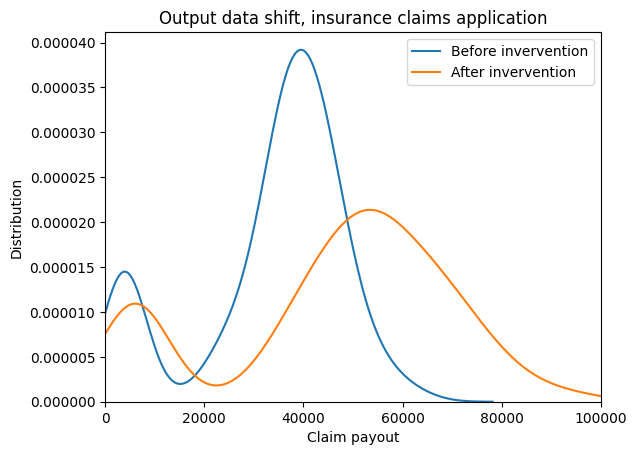

In [150]:
import seaborn as sns
sns.color_palette("colorblind")

normal_df = pd.read_csv(f"data/normal_4.csv", sep=",", header=0)
broken_data_df = pd.read_csv(f"data/broken_data_4.csv", sep=",", header=0)

plt.xlim(0, 100_000)
sns.kdeplot(normal_df["output"], label="Before invervention");
sns.kdeplot(broken_data_df["output"], label="After invervention");
plt.xlabel("Claim payout")
plt.ylabel("Distribution")
plt.ticklabel_format(style='plain', axis='y')
plt.legend()
plt.title("Output data shift, insurance claims application");
plt.savefig("insurance-claims-distribution-shift.pdf", bbox_inches='tight')

plt.show()
# plt.yticks([0, 1, 2, 3, 4]);

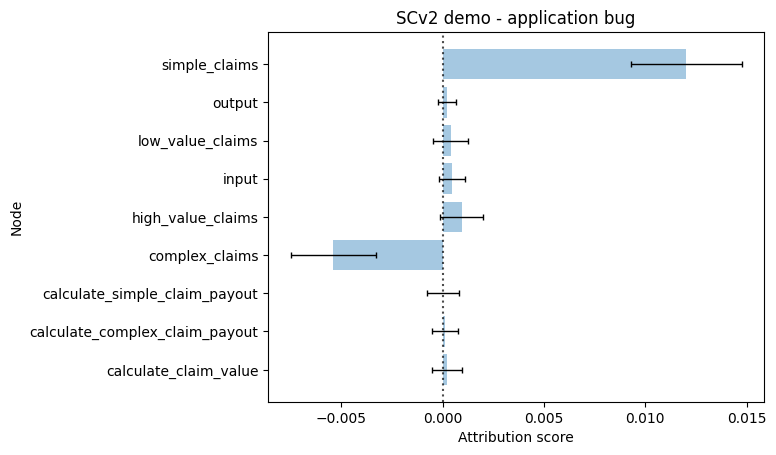

In [100]:
import math
records_count = broken_app_attr_df.shape[0]
records_means = broken_app_attr_df.mean(axis=0).to_list()
records_std = broken_app_attr_df.std(axis=0).to_list()
columns = broken_app_attr_df.columns.to_list()

ci95_lower = []
ci95_range = []
for m, s in zip(records_means, records_std):
    lower = m - 1.96*s/math.sqrt(records_count)
    ci95_lower.append(lower)
    ci95_range.append(m - lower)

import matplotlib.pyplot as plt

plt.barh(range(len(records_means)), records_means, xerr=ci95_range, alpha=0.4, align='center', error_kw={'capsize':2, 'elinewidth':1})
plt.yticks(range(len(records_means)), columns)
# plt.xscale('log')
plt.xlabel('Attribution score')
plt.ylabel('Node')
# plt.yticks(fontsize=12)
# plt.xscale('symlog', base=10, linscale=1000, linthresh=0.1)
# plt.xticks([-0.005, 0, 0.01])
plt.axvline(0, color='black', alpha=0.7, linestyle='dotted')
plt.title('SCv2 demo - application bug')
plt.savefig("scv2-bug.pdf", bbox_inches='tight')
plt.show()


In [93]:
attributions_per_experiment = []
for i in range(n_repeats):
    normal_df = pd.read_csv(f"data/normal_{i}.csv", sep=",", header=0)
    broken_data_df = pd.read_csv(f"data/broken_data_{i}.csv", sep=",", header=0)
    attributions = gcm.distribution_change(get_causal_model(), normal_df, broken_data_df, 'output')
    attributions_per_experiment.append(attributions)

broken_data_attr_df = pd.DataFrame(attributions_per_experiment)

Estimating Shapley Values. Average change of Shapley values in run 10 (50 evaluated permutations): -5.013603884664844%: 100%|██████████| 1/1 [00:00<00:00,  1.12it/s]
Estimating Shapley Values. Average change of Shapley values in run 4 (20 evaluated permutations): -16.341893622818706%: 100%|██████████| 1/1 [00:00<00:00,  2.13it/s]
Estimating Shapley Values. Average change of Shapley values in run 7 (35 evaluated permutations): -7.3738534768497%: 100%|██████████| 1/1 [00:00<00:00,  1.57it/s]
Estimating Shapley Values. Average change of Shapley values in run 4 (20 evaluated permutations): -3.161610989841014%: 100%|██████████| 1/1 [00:00<00:00,  2.05it/s]
Estimating Shapley Values. Average change of Shapley values in run 10 (50 evaluated permutations): -14.08052422613948%: 100%|██████████| 1/1 [00:00<00:00,  1.07it/s]
Estimating Shapley Values. Average change of Shapley values in run 5 (25 evaluated permutations): -3.4753087262886124%: 100%|██████████| 1/1 [00:00<00:00,  1.78it/s]
Estimati

In [94]:
from scipy import stats

for column in  broken_data_attr_df.columns:
    if column == "input":
        continue
    
    test_result = stats.ttest_ind(broken_data_attr_df["input"].to_list(),
                                  broken_data_attr_df[column].to_list(),
                                  equal_var=False)
    
    print(f"{column}: p-value = {test_result.pvalue}")

calculate_claim_value: p-value = 4.0920143984169686e-17
calculate_complex_claim_payout: p-value = 5.4496630996892904e-09
calculate_simple_claim_payout: p-value = 1.7083018060732055e-24
complex_claims: p-value = 1.858217326004084e-17
high_value_claims: p-value = 1.0717071418472643e-22
low_value_claims: p-value = 3.151864968049525e-20
output: p-value = 2.2956694411504558e-17
simple_claims: p-value = 2.899450047330449e-17


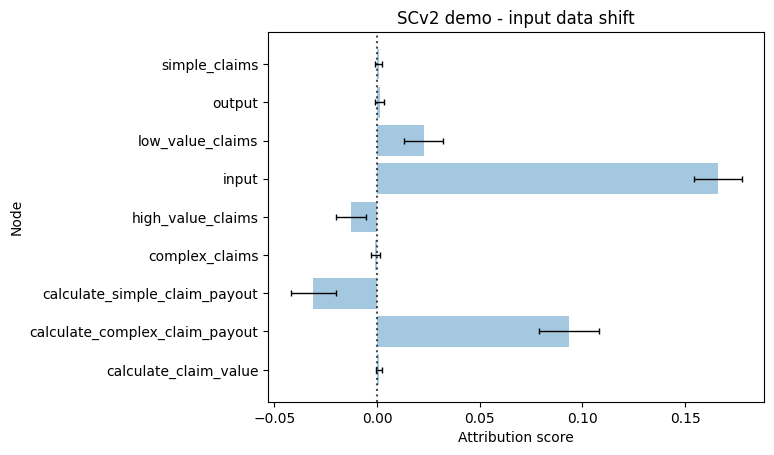

In [98]:
import math
records_count = broken_data_attr_df.shape[0]
records_means = broken_data_attr_df.mean(axis=0).to_list()
records_std = broken_data_attr_df.std(axis=0).to_list()
columns = broken_data_attr_df.columns.to_list()

ci95_lower = []
ci95_range = []
for m, s in zip(records_means, records_std):
    lower = m - 1.96*s/math.sqrt(records_count)
    ci95_lower.append(lower)
    ci95_range.append(m - lower)

import matplotlib.pyplot as plt

plt.barh(range(len(records_means)), records_means, xerr=ci95_range, alpha=0.4, align='center', error_kw={'capsize':2, 'elinewidth':1})
plt.yticks(range(len(records_means)), columns)
# plt.xscale('log')
plt.xlabel('Attribution score')
plt.ylabel('Node')
# plt.yticks(fontsize=12)
# plt.xscale('symlog', base=10, linscale=1000, linthresh=0.1)
# plt.xticks([-0.005, 0, 0.01])
plt.axvline(0, color='black', alpha=0.7, linestyle='dotted')
plt.title('SCv2 demo - input data shift')

plt.savefig("scv2-input.pdf", bbox_inches='tight')
plt.show()
